In [11]:
import sys
import math

sys.path.append('cryoem/')
sys.path.append('cryoem/util')

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

import pandas as pd

mpl.rcParams['figure.dpi'] = 150
plt.style.use(['dark_background'])

In [2]:
def read_starfile_angles(path):
    # Read the theoretical starfile
    # We only want (1-indexed): 2 (psi), 3 (phi), 4 (theta)
    # BEWARE skiprows, starfile header lengths may vary
    raw = pd.read_csv(path, delim_whitespace=True, header=None, skiprows=21)
    angles = raw[raw.columns[[1, 2, 3]]]
    angles.columns = [ 'psi', 'phi', 'theta']
    angles = angles.astype(float)
    angles['quaternion'] = angles.apply(lambda row: euler2quat(row.phi*np.pi/180, row.theta*np.pi/180, row.psi*np.pi/180), axis=1)

    return angles, raw

In [3]:
# Euler angles to Quaternion (from https://github.com/asarnow/pyem geom.py)
def euler2quat(alpha, beta, gamma):
    ha, hb, hg = alpha / 2, beta / 2, gamma / 2
    ha_p_hg = ha + hg
    hg_m_ha = hg - ha
    q = [np.cos(ha_p_hg) * np.cos(hb),
                  np.sin(hg_m_ha) * np.sin(hb),
                  np.cos(hg_m_ha) * np.sin(hb),
                  np.sin(ha_p_hg) * np.cos(hb)]
    return q

# Quaternion to Euler Angles (from https://github.com/asarnow/pyem geom.py)
def quat2euler(q):
    ha1 = np.arctan2(q[1], q[2])
    ha2 = np.arctan2(q[3], q[0])
    alpha = ha2 - ha1  # np.arctan2(r21/r20)
    beta = 2 * np.arccos(np.sqrt(q[0]**2 + q[3]**2))  # np.arccos*r33
    gamma = ha1 + ha2  # np.arctan2(r12/-r02)
    return float(alpha*(180/np.pi)), float(beta*(180/np.pi)), float(gamma*(180/np.pi))

# Angular distance between two quaternions
def quatDist(a,b):
    # Check to verify that quaternions are unit lengths
    assert abs(math.sqrt(a[0]**2+a[1]**2+a[2]**2+a[3]**2)-1)<.001,"a is not a unit quaternion"
    assert abs(math.sqrt(b[0]**2+b[1]**2+b[2]**2+b[3]**2)-1)<.001,"b is not a unit quaternion"
    
    # Compute distance
    s = a[0]*b[0] + a[1]*b[1] + a[2]*b[2] + a[3]*b[3]
    s = 2*(s**2)-1
    return np.arccos(s)*180/np.pi

def quatConj(q):
    # Compute the conjugate of quaternion q
    return [q[0], -1*q[1], -1*q[2], -1*q[3]]

def quatMult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return w, x, y, z

def quatInv(a):
    denom = a[0]**2 + a[1]**2 + a[2]**2 + a[3]**2
    return [a[0]/denom, -1*a[1]/denom, -1*a[2]/denom, -1*a[3]/denom]

def quatMag(a):
    return np.sqrt(a[0]**2 + a[1]**2 + a[2]**2 + a[3]**2)

def quat2aa(q):
    theta = 2*np.arccos(q[0])
    x = q[1]/np.sqrt(1-q[0]**2)
    y = q[2]/np.sqrt(1-q[0]**2)
    z = q[3]/np.sqrt(1-q[0]**2)
    return theta, [x,y,z]

In [4]:
def computePerturbedAngle(q1, theta):
    # pick the angular error distance to apply to this particle
#     d = abs(np.random.normal(0, sigma_angle ,1))
    d = theta
    
    # the first component dq_0 is given by the following:
    dq0 = np.sqrt((1+np.cos(d*(np.pi/180)))/2)

    # the components dq_1,2,3 are given in terms of two random numbers on [0,1] u_1 and u_2:
    u1 = np.random.uniform(0,1,1)
    u2 = np.random.uniform(0,1,1)

    dq1 = z = 2*u1 - 1
    dq2 = np.sqrt(1-z**2)*np.cos(2*np.pi*u2)
    dq3 = np.sqrt(1-z**2)*np.sin(2*np.pi*u2)

    norm = np.sqrt((1-np.cos(d*(np.pi/180)))/2)

    dq1 = dq1*norm
    dq2 = dq2*norm
    dq3 = dq3*norm

    dq = [dq0, dq1, dq2, dq3]

    qx = quatMult(quatMult(dq,q1),quatConj(dq))

    return qx

In [5]:
print('Reading starfile...')
data, raw = read_starfile_angles('../output/test.star')
print('Read %d particles.' % len(data))

theta = 15
perturbedAngles = [computePerturbedAngle(i,theta) for i in data.quaternion.tolist()]

print('Computed perturbed angles with %d degree fixed distance.' % theta)

eulerAngles = [quat2euler(i) for i in perturbedAngles]
col1 = [i[2] for i in eulerAngles]
col2 = [i[0] for i in eulerAngles]
col3 = [i[1] for i in eulerAngles]

# Euler angles from quat2euler are in order: phi, theta, psi
# Need to write the output in order: psi, phi, theta

# just need to replace 1, 2, 3 in "raw" eulerAngles 3, 1, 2
raw[1] = col1
raw[2] = col2
raw[3] = col3

header = "\ndata_images\n\nloop_\n_rlnAmplitudeContrast #1 \n_rlnAnglePsi #2 \n_rlnAngleRot #3 \n_rlnAngleTilt #4 \n_rlnClassNumber #5 \n_rlnDefocusAngle #6 \n_rlnDefocusU #7 \n_rlnDefocusV #8 \n_rlnDetectorPixelSize #9 \n_rlnImageName #10 \n_rlnMagnification #11 \n_rlnOriginX #12 \n_rlnOriginY #13 \n_rlnPhaseShift #14 \n_rlnSphericalAberration #15\n_rlnVoltage #16\n\n"
content = raw.to_csv(sep = ' ', header=False, index=False)
final = header+content

# Write
outFile = open("out.star", "w")

outFile.write(final)

outFile.close()


Reading starfile...
Read 100 particles.
Computed perturbed angles with 15 degree fixed distance.


<IPython.core.display.Javascript object>


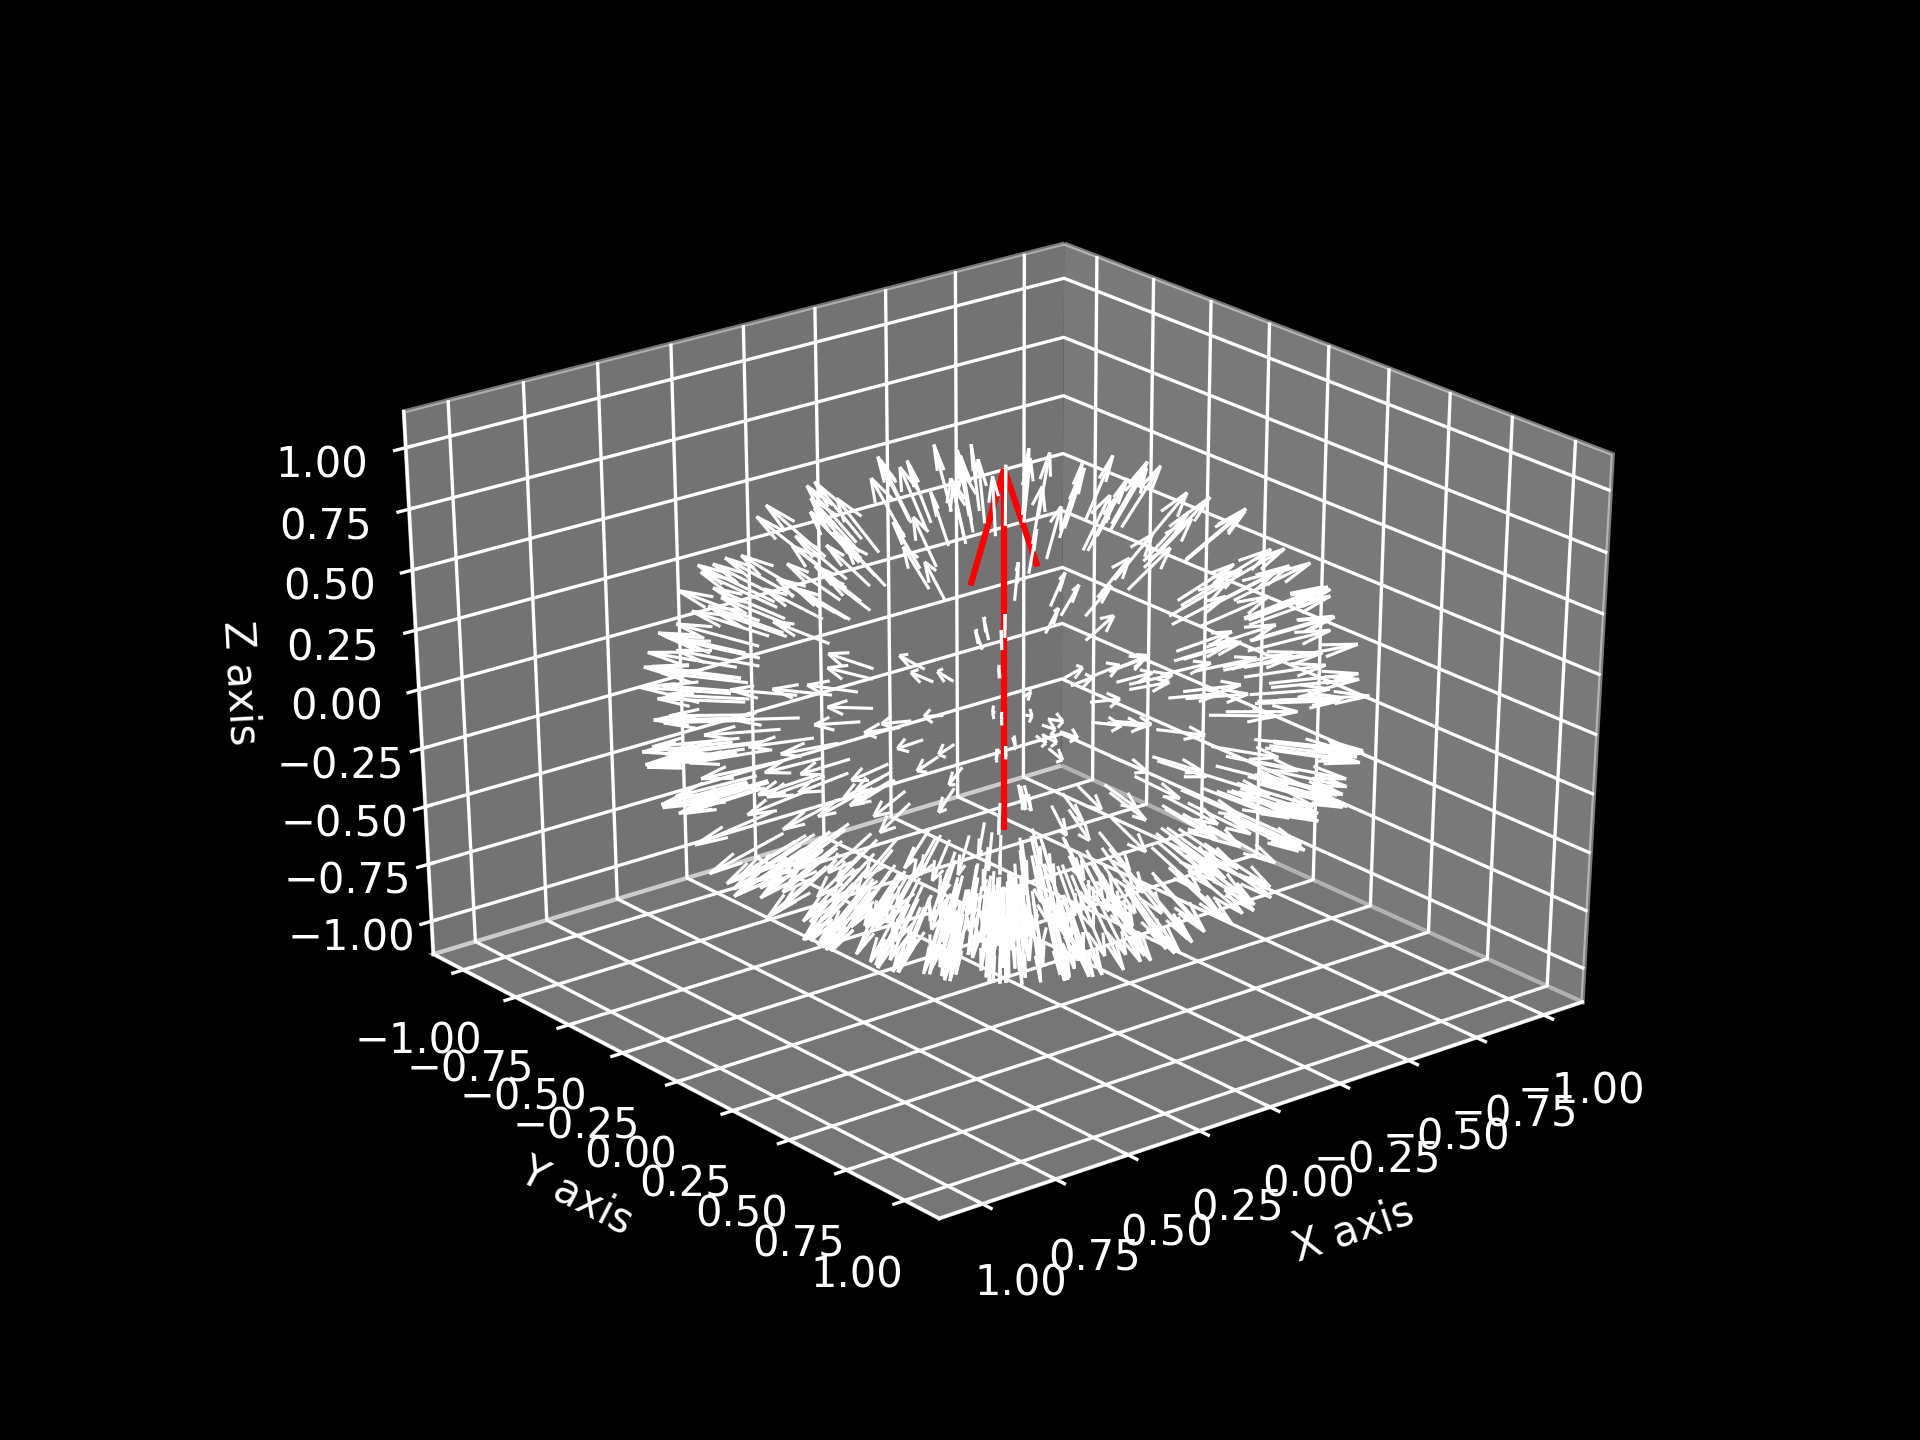

In [13]:

# Initial Euler angles (example)
psi = 90 *(np.pi/180)
rot = 0 *(np.pi/180)
tilt = 0 *(np.pi/180)
# calculate the quaternion of the theoretical orientation from the euler angles
q1 = euler2quat(psi, rot, tilt)


qxs = []
for i in range(500):
    qx = computePerturbedAngle(q1, 180)
    qxs.append(quat2aa(qx)[1])

v = qxs

X = [float(i[0]) for i in v]
Y = [float(i[1]) for i in v]
Z = [float(i[2]) for i in v]

fig = plt.figure()
ax = plt.axes(projection="3d")
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_zlim([-1.1, 1.1])
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')


ax.quiver(X,Y,Z,X,Y,Z,length=.25,pivot='tip', arrow_length_ratio = .4, normalize=True,linewidths=.75)
ax.quiver(quat2aa(q1)[1][0],quat2aa(q1)[1][1],quat2aa(q1)[1][2],quat2aa(q1)[1][0],quat2aa(q1)[1][1],quat2aa(q1)[1][2],length=1.5,pivot='tip',color='r')

ax.view_init(elev=0, azim=90)
fig.savefig("0.png")
